# Statistical Methods in Astrophysics Exercises

## Week 01: Probability Theory

### Personal Information

**Name:** physnya



### Exercise 1: Flood risk simulation

A dam is built in a region where days are sunny or rainy, each with a long-term stable probability of 0.5. A flood occurs if there are at least 7 consecutive rainy days in a row; a long run of rainy days is counted only once.

#### Question 1.1: A plain Monte-Carlo simulation

**Task:** Simulate 10,000 years of weather data with independent and identically distributed probabilities of sunny and rainy days. Estimate the expected number of floods per 365-day year.

**Hint:** You may generate binary random numbers to represent sunny and rainy days, e.g., 0 for sunny and 1 for rainy. 


In [1]:
# NOTE: Run this cell in the first place
# Load packages for numerical calculations and plotting
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9.6, 5.4)
# Enable inline plotting in Jupyter notebooks
%matplotlib inline

In [2]:
# A helper function to return the lengths of consecutive runs of 1s in a binary array
def consecutive_ones(arr):
    """Return the lengths of consecutive 1s in a binary array."""
    # Identify the start and end indices of sequences of 1s
    changes = np.diff(arr, prepend = 0, append = 0)
    start_indices = np.where(changes == 1)[0]
    end_indices = np.where(changes == -1)[0]
    # Calculate the lengths of these sequences
    lengths = end_indices - start_indices
    return lengths

In [3]:
# Set the random seed
seed = 2024011182 # NOTE: EDIT HERE to insert your seed as the seed
nsample = 365 * 10000 # number of days to simulate

rng = np.random.default_rng(seed)
weather = rng.integers(0, 2, size = nsample) # 0 for sunny, 1 for rainy

# Validate the overall fraction of rainy days
print(f'Fraction of rainy days: {weather.mean():.4%}')

Fraction of rainy days: 49.9785%


In [4]:
# Get the lengths of consecutive rainy days
rainy_lengths = consecutive_ones(weather)

# NOTE: EDIT BELOW to compute the expected number of floods per year
flood_events = np.sum(consecutive_ones(weather) >= 7)
print(flood_events.sum() / (nsample / 365))

1.4178


#### Question 1.2: Markov-chain Monte-Carlo (MCMC) simulation

In reality, weather conditions are correlated in time. For example, a rainy day is more likely to be followed by another rainy day. We can model the weather as a two-state Markov chain with the following transition matrix:

$$
T = 
\begin{bmatrix}
P(S \to S) & P(S \to R) \\
P(R \to S) & P(R \to R)
\end{bmatrix}
$$

where $S$ and $R$ denote sunny and rainy days, respectively. $P(S \to S)$ is the probability of a sunny day being followed by another sunny day, and so on.

Assume that $P(S \to S) = P(R \to R) = 0.7$.

**Tasks:**
1. Complete the transition matrix and implement a Markov chain simulation to generate weather data in 100 years. Estimate the expected number of floods per 365-day year.
2. Plot the histogram of the lengths of consecutive rainy days obtained from both simulations in Questions 1.1 and 1.2. Choose appropriate bin sizes, ranges, and axes scales to clearly show the differences between the two distributions.
3. Comment on the differences between the two distributions.

In [5]:
def markov_chain_simulation(transition_matrix, n_steps, seed = 42):
    """Markov-chain Monte-Carlo simulation of weather data.
    Args:
        transition_matrix (2x2 array): transition probabilities.
        n_steps (int): Number of steps to simulate.
        seed (int): Random seed for reproducibility.
    Returns: weather sequence
    """
    rng = np.random.default_rng(seed)
    current_state = rng.choice([0, 1]) # Start from a random state
    states= [current_state]

    for _ in range(n_steps - 1):
        prob = transition_matrix[current_state]
        next_state = rng.choice([0, 1], p = prob)
        states.append(next_state)
        current_state = next_state

    return np.array(states)

In [6]:
nsample = 365 * 100 # number of days to simulate
# NOTE: EDIT BELOW to complete the transition matrix simulate
transition_matrix = np.array([[0.7, 0.3],
                              [0.3, 0.7]])

weather_mc = markov_chain_simulation(transition_matrix, nsample, seed = seed)

# Validate the overall fraction of rainy days
print(f'Fraction of rainy days (Markov chain): {weather_mc.mean():.4%}')

Fraction of rainy days (Markov chain): 51.1836%


In [7]:
# Get the lengths of consecutive rainy days
rainy_lengths_mc = consecutive_ones(weather_mc)

# NOTE: EDIT BELOW to compute the expected number of floods per year
flood_events_mc = np.sum(consecutive_ones(weather_mc) >= 7)
print(flood_events_mc.sum() / (nsample / 365))

6.72


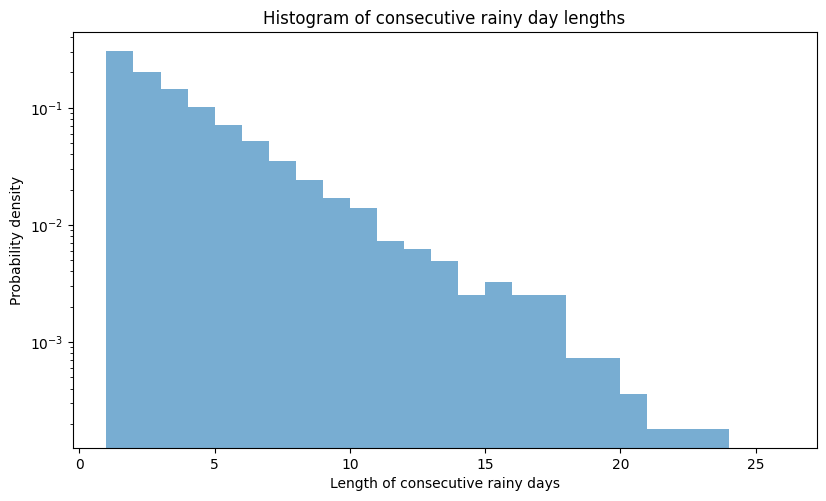

In [8]:
# NOTE: EDIT BELOW to plot the histogram of lengths of rainy day runs
bins = np.arange(1, rainy_lengths_mc.max())

plt.hist(
    rainy_lengths_mc, 
    bins = bins, 
    alpha = 0.6,
    label = 'Markov Chain',
    density = True
)
plt.xlabel('Length of consecutive rainy days')
plt.ylabel('Probability density')
plt.yscale('log')
plt.title('Histogram of consecutive rainy day lengths')
plt.show()

##### Discussions

很明显地发现 Markov 链方法和之前随机生成的方法在降雨概率上分别并不大，但是对于连续降雨的估计要合理很多 ($50\%$ 时间都在下雨的地方一年怎么可能只有不到两次洪水...6 次相对来说更加合理).

#### Question 1.3: Weather simulation with more states

Suppose the weather can be sunny (S), cloudy (C), or rainy (R). The transition matrix is given by:

$$
T =
\begin{bmatrix}
P(S \to S) & P(S \to C) & P(S \to R) \\
P(C \to S) & P(C \to C) & P(C \to R) \\
P(R \to S) & P(R \to C) & P(R \to R)
\end{bmatrix}
=
\begin{bmatrix}
0.7 & 0.2 & 0.1 \\
0.3 & 0.5 & 0.2 \\
0.4 & 0.3 & 0.3
\end{bmatrix}
$$

We start with a sunny day.

**Tasks:**
1. Simulate the weather for 5 days. Run the simulation with 100 different random seeds. What is the probability of having a rainy day on the 5th day?
2. Simulate the weather for 100 days. Run the simulation with 100 different random seeds. For each $N$ in {2, 5, 10, 20, 50, 100}, plot the probabilities of being sunny, cloudy, and rainy on the $N$-th day as functions of $N$ with appropriate axes scales.
3. Comment on the results.


In [9]:
# Modify the Markov-chain simulation for three states: sunny, cloudy, and rainy
def markov_chain_simulation_3(transition_matrix, n_steps, seed = 42):
    """Markov-chain Monte-Carlo simulation of weather data with three states: 
        sunny (0), cloudy (1), and rainy(2).
    Args:
        transition_matrix (3x3 array): transition probabilities.
        n_steps (int): Number of steps to simulate.
        seed (int): Random seed for reproducibility.
    Returns: weather sequence
    """
    rng = np.random.default_rng(seed)
    current_state = 0 # Start from a sunny day
    states= [current_state]

    for _ in range(n_steps - 1):
        prob = transition_matrix[current_state]
        next_state = rng.choice([0, 1, 2], p = prob)
        states.append(next_state)
        current_state = next_state

    return np.array(states)

In [10]:
transition_matrix_3 = np.array([[0.7, 0.2, 0.1],
                                [0.3, 0.5, 0.2],
                                [0.4, 0.3, 0.3]])
nsample = 5 # number of days to simulate
seeds = [seed + i for i in range(100)] # Different seeds based on seed
is_rainy = [] # To store if the 5th day is rainy for each simulation

for s in seeds:
    weather_3 = markov_chain_simulation_3(transition_matrix_3, nsample, seed = s)
    is_rainy.append(weather_3[-1] == 2) # Check if the 5th day is rainy

# NOTE: EDIT BELOW to compute the probability of rainy on the 5th day
rainy_prob = np.count_nonzero(is_rainy) / len(is_rainy)
print(f'Probability of rainy on the 5th day: {rainy_prob:.2f}')

Probability of rainy on the 5th day: 0.18


In [11]:
nsample = 100 # number of days to simulate
days = np.array([2, 5, 10, 20, 50, 100, 200, 500, 1000])
weather_states = [[] for _ in days] # To store weather states for different days

for s in seeds:
    weather_3 = markov_chain_simulation_3(transition_matrix_3, nsample, seed = s)
    for i, day in enumerate(days):
        # NOTE: EDIT HERE to append the weather state on the specified day
        weather_states[i].append(weather_3[i])

sunny_probs = []
cloudy_probs = []
rainy_probs = []

for states in weather_states:
    states = np.array(states)
    
    # NOTE: EDIT HERE and BELOW to compute the probabilities of different weather states
    sunny_probs.append(np.count_nonzero(states == 0) / len(states))
    cloudy_probs.append(np.count_nonzero(states == 1) / len(states))
    rainy_probs.append(np.count_nonzero(states == 2) / len(states))

print(sunny_probs)
print(cloudy_probs)
print(rainy_probs)

[1.0, 0.67, 0.62, 0.54, 0.51, 0.46, 0.53, 0.45, 0.53]
[0.0, 0.2, 0.26, 0.34, 0.31, 0.37, 0.31, 0.42, 0.34]
[0.0, 0.13, 0.12, 0.12, 0.18, 0.17, 0.16, 0.13, 0.13]


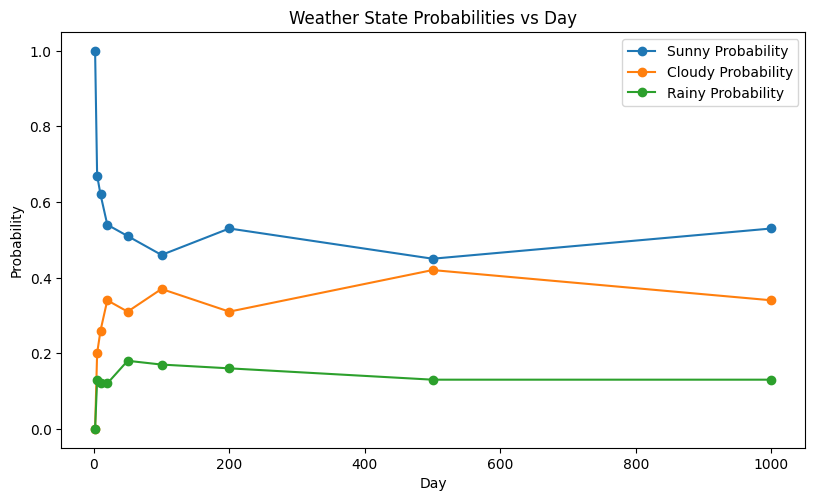

In [12]:
# NOTE: EDIT BELOW to plot the probabilities of different weather states on different days
plt.plot(
    days,
    sunny_probs,
    marker = 'o',
    label = 'Sunny Probability'
)
plt.plot(
    days,
    cloudy_probs,
    marker = 'o',
    label = 'Cloudy Probability'
)
plt.plot(
    days,
    rainy_probs,
    marker = 'o',
    label = 'Rainy Probability'
)
plt.xlabel('Day')
plt.ylabel('Probability')
plt.title('Weather State Probabilities vs Day')
plt.legend()
plt.show()

##### Discussions

我们所看到的结果仍然是合理的：在矩阵中出现概率更高的晴天一开始概率最高，后来随着模拟天数的增加逐渐减少；雨天和多云逐渐变多. 当然，模拟得到的结果会有随机性，这体现在曲线中间出现的一些弯折上.

### Exercise 2: Stellar evolution simulation

A typical solar-mass star evolves through four stages: young (Y), main sequence (M), red giant (R), and white dwarf (W; resulting from supernova explosion). The transition matrix over a 10-million-year interval is given by (do not take the values too seriously; I made them up for this exercise):

$$
T = \begin{bmatrix}
P(Y \to Y) & P(Y \to M) & P(Y \to R) & P(Y \to W) \\
P(M \to Y) & P(M \to M) & P(M \to R) & P(M \to W) \\
P(R \to Y) & P(R \to M) & P(R \to R) & P(R \to W) \\
P(W \to Y) & P(W \to M) & P(W \to R) & P(W \to W)
\end{bmatrix}
= \begin{bmatrix}
0.5 & 0.5 & 0 & 0 \\
0 & 0.99 & 0.01 & 0 \\
0 & 0 & 0.9 & 0.1 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

#### Question 2.1: stellar age

**Task:** Simulate the life cycle of 1000 stars, and estimate the average age of a solar-mass star when it becomes a white dwarf using the 4-state Markov model.

In [13]:
def markov_chain_simulation_star(transition_matrix, n_steps, seed = 42):
    """Markov-chain Monte-Carlo simulation of stellar evolution with four states: 
        0 = Young, 1 = Main Sequence, 2 = Red Giant, 3 = White Dwarf.
    Args:
        transition_matrix (4x4 array): transition probabilities.
        n_steps (int): Number of steps to simulate.
        seed (int): Random seed for reproducibility.
    Returns: 
        stellar state sequence, with states represented as integers 0, 1, 2, 3.
    """
    rng = np.random.default_rng(seed)
    current_state = 0 # Start as young star
    states = [current_state]
    
    # NOTE: EDIT BELOW to complete the function
    for _ in range(n_steps - 1):
        prob = transition_matrix[current_state]
        next_state = rng.choice([0, 1, 2, 3], p = prob)
        states.append(next_state)
        current_state = next_state
    
    return np.array(states)

In [14]:
def stellar_age(states):
    """Calculate the age of a star based on its state sequence.
    Args:
        states (array): Sequence of stellar states.
    Returns: 
        age of the star in million years; 
        -1 if it never becomes a white dwarf
    """
    # First occurrence of state 3 (white dwarf)
    i = np.searchsorted(states, 3, side='left')
    if i < len(states) and states[i] == 3:
        # Age in million years
        return (i + 1) * 10
    else:
        # Never becomes a white dwarf
        return -1

In [15]:
stellar_transition_matrix = np.array([[0.5, 0.5, 0.0, 0.0],
                                      [0.0, 0.99, 0.01, 0.0],
                                      [0.0, 0.0, 0.9, 0.1],
                                      [0.0, 0.0, 0.0, 1.0]])

nsample = 1000 # number of stars to simulate
seeds = [seed + i for i in range(nsample)] # Different seeds based on seed
max_steps = 1000 # Maximum number of steps to simulate for each star
stellar_states = [] # To store the states of all stars

# Simulate the evolution of multiple stars
for s in seeds:
    states = markov_chain_simulation_star(stellar_transition_matrix, max_steps, seed = s)
    stellar_states.append(states)

stellar_states = np.array(stellar_states)

In [16]:
# Compute the ages of all stars
ages = np.array([stellar_age(states) for states in stellar_states])

# NOTE: EDIT BELOW to compute the average age; pay attention to stars that never become white dwarfs
# Only consider stars that became white dwarfs (age != -1)
valid_ages = ages[ages != -1]
average_age = valid_ages.mean()
print(f'Average age when becoming a white dwarf: {average_age:.2f} million years')

Average age when becoming a white dwarf: 1173.86 million years


#### Question 2.2: Stellar stage composition

**Task:** For the 1000 stars simulated in Question 2.1, plot the porportion of stars in each stage (Y, M, R, W) as a function of time (up to 10 billion years). Use appropriate axes scales.

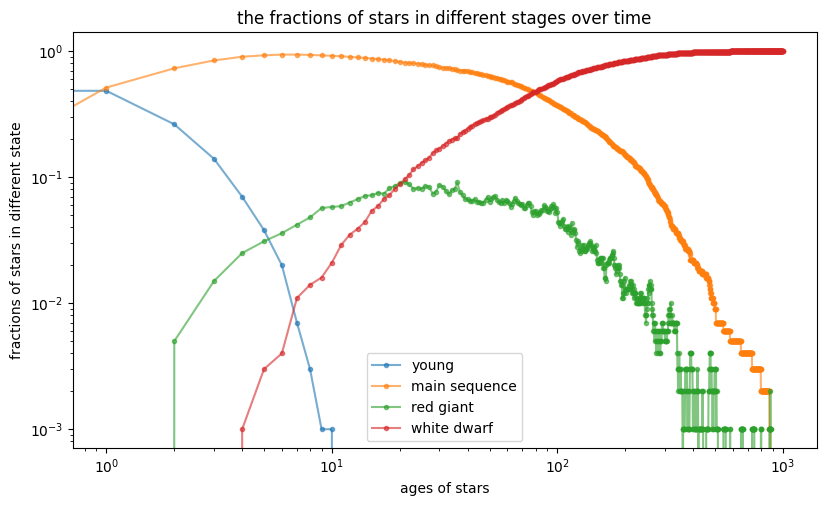

In [17]:
# Compute the fractions of stars in each stage over time
fractions = (stellar_states[..., None] == np.arange(4)).mean(axis = 0)
fracY, fracM, fracR, fracW = fractions.T

# NOTE: EDIT BELOW to plot the fractions of stars in different stages over time
plt.plot(
    fracY,
    marker = ".",
    label = "young",
    alpha = 0.6
)
plt.plot(
    fracM,
    marker = ".",
    label = "main sequence",
    alpha = 0.6
)
plt.plot(
    fracR,
    marker = ".",
    label = "red giant",
    alpha = 0.6
)
plt.plot(
    fracW,
    marker = ".",
    label = "white dwarf",
    alpha = 0.6
)
plt.xscale("log")
plt.yscale('log')
plt.xlabel("ages of stars")
plt.ylabel("fractions of stars in different state")
plt.title("the fractions of stars in different stages over time")
plt.legend()
plt.show()

#### Question 2.3: Stellar population with continuous formation

Assume that 1000 stars have formed at a constant rate over the past 10 billion years, i.e., the birth times of the stars can be drawn from a uniform distribution between 0 and 10 billion years.

**Task:** Compute the present-day (10 billion years after the first stellar birth) proportions of stars in each stage (Y, M, R, W) in this population.

**Hint:** Can you complete this task without running a new simulation?

In [18]:
rng = np.random.default_rng(seed - 1)
birth_times = rng.integers(0, 1000, size = nsample)   # Birth times of stars (unit: 10 million years)
today = 1000        # Present time (unit: 10 million years)

# Use the birth times to determine the current states of the stars
mask = birth_times < today
ages = today - birth_times[mask]
present_states = np.array([stellar_states[i, age - 1] if age - 1 < max_steps else 3 for i, age in zip(np.where(mask)[0], ages)])

# NOTE: EDIT BELOW to print the present-day proportions of stars in different stages
unique, counts = np.unique(present_states, return_counts = True)
stage_labels = ['Young', 'Main Sequence', 'Red Giant', 'White Dwarf']
proportions = np.zeros(4)
proportions[unique] = counts / len(present_states)

for i, label in enumerate(stage_labels):
    print(f"{label}: {proportions[i]:.1%}")

Young: 0.2%
Main Sequence: 10.5%
Red Giant: 0.9%
White Dwarf: 88.4%


### Exercise 3: Transient detection

A special type of astronomical transient event (e.g., a supernova explosion) starts on a random night of an observing season with 180 nights in total. The transient event lasts for $D$ consecutive nights and is only **confirmed** if it is observed in two consecutive nights within its duration.

#### Question 3.1: Detection probability with independent nights

Assume each night is independently clear (observable) with a probability of 0.6.

**Task:** For each $D$ in $\{2,4,8,12,16,20\}$, simulate 10,000 observing seasons and estimate the probability of confirming the transient event. Plot the detection probability as a function of $D$ with appropriate axes scales.

**Hint:** You may generate a binary random number sequence to represent clear and unusable nights, e.g., 0 for unusable and 1 for clear, then check if there are two consecutive 1s within the $D$ nights starting from a random night.


In [19]:
durations = [2, 4, 8, 12, 16, 20]

def generate_random_transient_event(duration, seed = 42):
    """generate a random transient event during one observing season of 180 nights:
    Args: 
        duration (int): the duration of a transient event.
        seed (int): Random seed for reproducibility.
    Returns:
        start_date (int): the starting date of a transient event.
        end_date (int): the ending date of a transient event.
    """
    rng_transient_event = np.random.default_rng(seed)
    
    start_date = rng_transient_event.integers(0, 180 - duration)
    end_date = start_date + duration
    
    return start_date, end_date

In [20]:
def generate_clear_nights(probability = 0.6, seed = 42):
    """generate a binary random number sequence for clear and unusable nights with probability:
        0 for unusable nights, 1 for clear nights.
    Args:
        probalbility (float): the probability of clear night.
        seed (int): Random seed for reproducibility.
    Returns:
        nights sequence, with clear and unusable nights represented as 1, 0.
    """
    rng_clear_night = np.random.default_rng(seed)
    nights = rng_clear_night.uniform(0, 1, 180)
    
    for i in range(0, 180):
        if (nights[i] <= probability):
            nights[i] = 1
        else:
            nights[i] = 0
    
    return nights

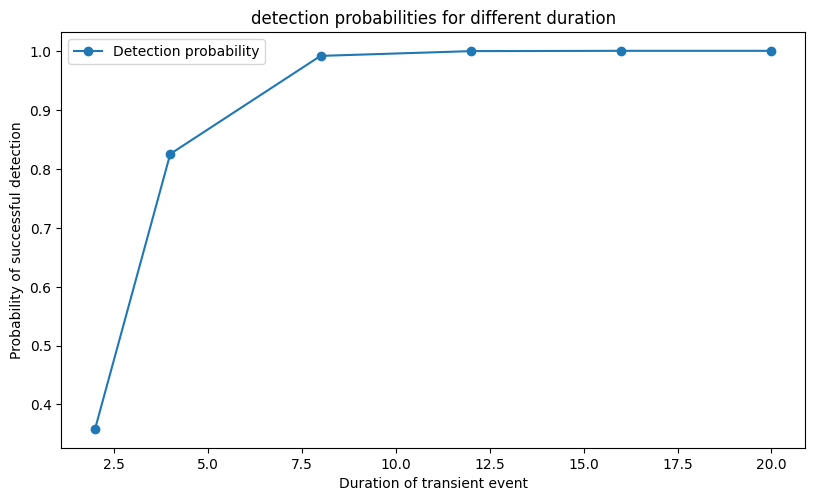

In [21]:
detection_probabilities = []

for duration in durations:
    success_observation = 0
    
    for i in range(0, 10000):
        start_date, end_date = generate_random_transient_event(duration, seed + i)
        nights = generate_clear_nights(probability = 0.6, seed = seed + i)
        num_clear = np.count_nonzero(nights[start_date:end_date] == 1)
        
        if (num_clear >= 2):
            success_observation += 1
        
    detection_probabilities.append(success_observation / 10000)
    
plt.plot(
    durations,
    detection_probabilities,
    marker = 'o',
    label = "Detection probability"
)
plt.xlabel('Duration of transient event')
plt.ylabel('Probability of successful detection')
plt.title('detection probabilities for different duration')
plt.legend()
plt.show()

#### Question 3.2: Detection probability with correlated weather

The weather conditions are correlated in time. For example, a clear night is more likely to be followed by another clear night. We can model the weather as a two-state Markov chain with the following transition matrix:

$$
T = 
\begin{bmatrix}
P(U \to U) & P(U \to C) \\
P(C \to U) & P(C \to C)
\end{bmatrix}
= \begin{bmatrix}
0.7 & 0.3 \\
0.2 & 0.8
\end{bmatrix}
$$

where $U$ and $C$ denote unusable and clear nights, respectively. $P(U \to U)$ is the probability of an unusable night being followed by another unusable night, and so on.

**Task:** Repeat Question 3.1 using the Markov chain model to simulate the weather. Confirm that the steady-state probability of clear nights is still 0.6. Compare your transient detection probability results with those from Question 3.1.

In [22]:
def generate_clear_nights_mc(transition_matrix_question_3, num_steps, seed = 42):
    """generate a binary random number sequence for clear and unusable nights with markov chain method:
        0 for unusable nights, 1 for clear nights.
    Args:
        transition_matrix_uc (2x2 array): transition probabilities.
        num_steps (int): the total steps of Markov chain.
        seed (int): Random seed for reproducibility.
    Returns:
        nights sequence, with clear and unusable nights represented as 1, 0.
    """
    rng_clear_night_mc = np.random.default_rng(seed)
    current_night_mc = rng_clear_night_mc.choice([0, 1]) # Start from a random state
    nights_mc = [current_night_mc]

    for _ in range(num_steps - 1):
        prob = transition_matrix_question_3[current_night_mc]
        next_night_mc = rng.choice([0, 1], p = prob)
        nights_mc.append(next_night_mc)
        current_night_mc = next_night_mc

    return np.array(nights_mc)

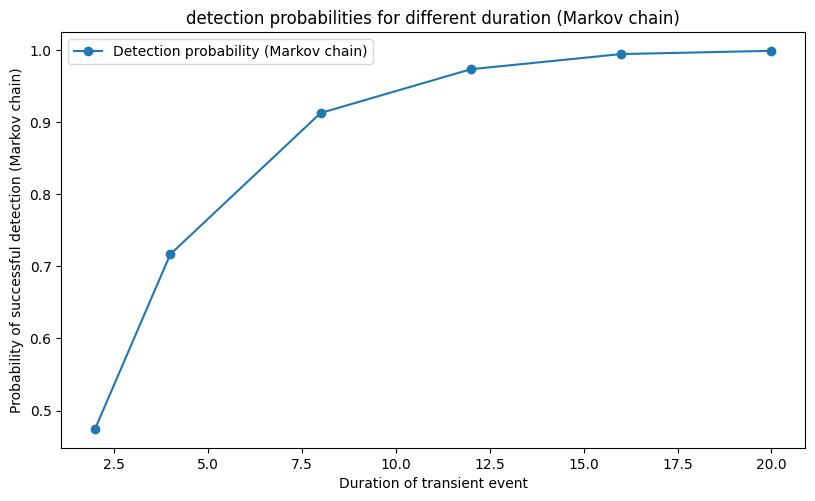

In [23]:
detection_probabilities_mc = []
transition_matrix_question_3 = np.array([[0.7, 0.3],
                                         [0.2, 0.8]])

for duration in durations:
    success_observation = 0
    
    for i in range(0, 10000):
        start_date, end_date = generate_random_transient_event(duration, seed + i)
        nights = generate_clear_nights_mc(transition_matrix_question_3, num_steps = 180, seed = seed + i)
        num_clear = np.count_nonzero(nights[start_date:end_date] == 1)
        
        if (num_clear >= 2):
            success_observation += 1
        
    detection_probabilities_mc.append(success_observation / 10000)
    
plt.plot(
    durations,
    detection_probabilities_mc,
    marker = 'o',
    label = "Detection probability (Markov chain)"
)
plt.xlabel('Duration of transient event')
plt.ylabel('Probability of successful detection (Markov chain)')
plt.title('detection probabilities for different duration (Markov chain)')
plt.legend()
plt.show()

#### Question 3.3: Detection probability with cadence gaps

Not all clear nights are usable for transient detection due to various reasons (e.g., the moon is too bright). Assume that in every 29 nights, the first 5 nights are unusable for transient detection (even if the skies are clear).

**Task:** Repeat Question 3.2 with this additional constraint. Compare your results with those from Question 3.2. Comment on all your results.

**Hint:** You may use the modulo operator (`%`) to identify the nights that are unusable for transient detection, or use a predefined mask array to represent the cadence gaps. You do not have to rerun the weather simulation; just apply the cadence gaps to the results from Question 3.2.

In [24]:
def generate_clear_nights_mc_gaps(transition_matrix_question_3_gaps, num_steps, seed = 42):
    """generate a binary random number sequence for clear and unusable nights with markov chain method, considering the gaps:
        0 for unusable nights, 1 for clear nights.
    Args:
        transition_matrix_uc (2x2 array): transition probabilities.
        num_steps (int): the total steps of Markov chain.
        seed (int): Random seed for reproducibility.
    Returns:
        nights sequence, with clear and unusable nights represented as 1, 0.
    """
    rng_clear_night_mc_gaps = np.random.default_rng(seed)
    current_night_mc_gaps = rng_clear_night_mc_gaps.choice([0, 1]) # Start from a random state
    nights_mc_gaps = [current_night_mc_gaps]

    for _ in range(num_steps - 1):
        prob = transition_matrix_question_3_gaps[current_night_mc_gaps]
        next_night_mc_gaps = rng.choice([0, 1], p = prob)
        nights_mc_gaps.append(next_night_mc_gaps)
        current_night_mc_gaps = next_night_mc_gaps
        
    # the first 5 nights of 29 nights are unusable
    for i in range(0, num_steps):
        if i % 29 < 5:
            nights_mc_gaps[i] = 0

    return np.array(nights_mc_gaps)

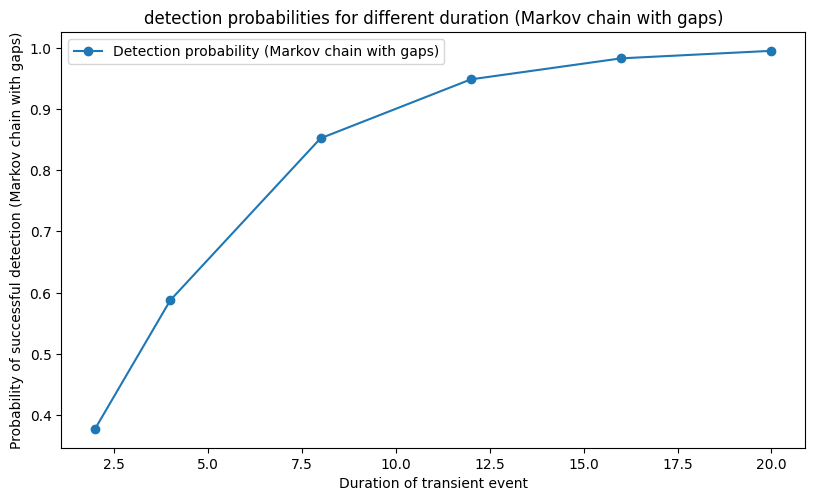

In [25]:
detection_probabilities_mc_gaps = []
transition_matrix_question_3_gaps = np.array([[0.7, 0.3],
                                              [0.2, 0.8]])

for duration in durations:
    success_observation_gaps = 0
    
    for i in range(0, 10000):
        start_date_gaps, end_date_gaps = generate_random_transient_event(duration, seed + i)
        nights_gaps = generate_clear_nights_mc_gaps(transition_matrix_question_3_gaps, num_steps = 180, seed = seed + i)
        num_clear_gaps = np.count_nonzero(nights_gaps[start_date_gaps:end_date_gaps] == 1)
        
        if (num_clear_gaps >= 2):
            success_observation_gaps += 1
        
    detection_probabilities_mc_gaps.append(success_observation_gaps / 10000)
    
plt.plot(
    durations,
    detection_probabilities_mc_gaps,
    marker = 'o',
    label = "Detection probability (Markov chain with gaps)"
)
plt.xlabel('Duration of transient event')
plt.ylabel('Probability of successful detection (Markov chain with gaps)')
plt.title('detection probabilities for different duration (Markov chain with gaps)')
plt.legend()
plt.show()

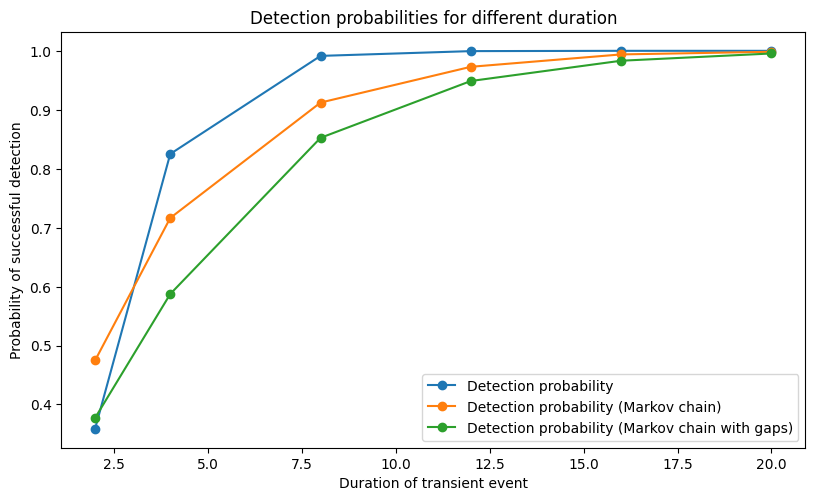

In [26]:
plt.plot(
    durations,
    detection_probabilities,
    marker = 'o',
    label = "Detection probability"
)
plt.plot(
    durations,
    detection_probabilities_mc,
    marker = 'o',
    label = "Detection probability (Markov chain)"
)
plt.plot(
    durations,
    detection_probabilities_mc_gaps,
    marker = 'o',
    label = "Detection probability (Markov chain with gaps)"
)
plt.xlabel('Duration of transient event')
plt.ylabel('Probability of successful detection')
plt.title('Detection probabilities for different duration')
plt.legend()
plt.show()

##### Discussions

定性上，还是 duration 越长，能够成功探测到的概率越大. 其实这个「每月前五天无法成功观测」的限制只是在整体上降低了概率，并没有影响整体的趋势.

### Note: steps for submitting the exercise

1. In the menu bar, select `File > Download` to download your notebook as a `.ipynb` file.
2. Select `File > Save and Export Notebook As > PDF` to export your notebook as a PDF file.
3. Combine the `.ipynb` and `.pdf` files into a single `.zip` or `.tar.gz` archive.
4. Upload your archive to the web learning platform (网络学堂).